# <center> <span style="font-family: Virgil GS, sans-serif; color:#97f788">Fairness in Credit Scoring</span> </center>
## <center> <span style="font-family: Virgil GS, sans-serif; color:navyblue">Bias mitigation tools</span> </center>


 <span style="font-family: Virgil GS, sans-serif; color:navyblue">Author: <a href="https://github.com/deburky" title="GitHub link">https://github.com/deburky</a></span>

In [2]:
import numpy as np
import pandas as pd

np.random.seed(0)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

In [51]:
from matplotlib import pyplot as plt

plt.rcParams["font.family"] = "Virgil GS"

In [74]:
# Fetch loan approval data (synthesized)
url = (
    "https://drive.google.com/file/d/1r6gGvL_s313ThGSU7ziZiuYr2G_yijaZ/view?usp=sharing"
)
file_id = url.split("/")[-2]
dataset = pd.read_csv(f"https://drive.google.com/uc?id={file_id}")

In [75]:
sensitive_columns = ["Gender"]
condition_gender = dataset["Gender"] == "Female"

categorical_features = [
    "Married",
    "Dependents",
    "Education",
    "Self_Employed",
    "Property_Area",
]

dataset["Sensitive_Group"] = np.where(condition_gender, 1, 0)
print(dataset["Sensitive_Group"].mean())

dataset["Loan_Status"] = np.where(dataset["Loan_Status"].isin(["Y"]), 1, 0)

0.1776


In [5]:
display(dataset.groupby("Gender").agg(approval_rate=("Loan_Status", "mean")))

,approval_rate
Gender,
Female,0.640203
Male,0.731494


In [6]:
# from https://fairlearn.org/main/auto_examples/plot_credit_loan_decisions.html


def resample_training_data(X, y, A):
    """Down-sample the majority class in the training dataset to produce a
    balanced dataset with a 50/50 split in the predictive labels.

    Parameters:
    X: The training split of the features
    y: The training split of the target labels
    A: The training split of the sensitive features

    Returns:
    Tuple of X_train, Y_train, A_train where each dataset has been re-balanced.
    """
    common_indices = X.index.intersection(y.index).intersection(A.index)
    X = X.loc[common_indices, :]
    y = y.loc[common_indices]
    A = A.loc[common_indices]

    negative_ids = y[y == 0].index
    positive_ids = y[y == 1].index
    balanced_ids = positive_ids.union(
        np.random.choice(a=negative_ids, size=len(positive_ids))
    )

    X_resampled = X.loc[balanced_ids, :]
    y_resampled = y.loc[balanced_ids]
    A_resampled = A.loc[balanced_ids]
    return X_resampled, y_resampled, A_resampled

In [7]:
# Load your dataset and preprocess it
X = dataset.drop(["Loan_ID"] + sensitive_columns, axis=1)
y = X.pop("Loan_Status")
A = X.pop("Sensitive_Group")

# Split your data into an initial train and test set
ix_train, ix_test = train_test_split(
    X.index, test_size=0.3, random_state=42, stratify=y
)

print(f"Average approval rate before resampling: {y.mean():.2%}")

# Resample your training data for balancing
X_train, y_train, A_train = resample_training_data(
    X.loc[ix_train], y.loc[ix_train], A.loc[ix_train]
)

# Resample your test data to ensure consistency in rebalancing
X_test, y_test, A_test = resample_training_data(
    X.loc[ix_test], y.loc[ix_test], A.loc[ix_test]
)

# Concatenate the resampled data to have complete X, y, and A
X_b, y_b, A_b = (
    pd.concat([X_train, X_test]),
    pd.concat([y_train, y_test]),
    pd.concat([A_train, A_test]),
)

X_b.reset_index(drop=True, inplace=True)
y_b.reset_index(drop=True, inplace=True)
A_b.reset_index(drop=True, inplace=True)

# Assign indexes on new data
ix_train_b, ix_test_b = y_train.index, y_test.index

print(f"Average approval rate after resampling: {y_b.mean():.2%}")

# Convert categorical features to category data type
for cat in categorical_features:
    X_b[cat] = X_b[cat].astype("category")

Average approval rate before resampling: 70.89%
Average approval rate after resampling: 50.00%


In [13]:
display(
    pd.concat([X_b, y_b, A_b], axis=1)
    .groupby("Sensitive_Group")
    .agg(approval_rate=("Loan_Status", "mean"))
)

,approval_rate
Sensitive_Group,
0,0.517475
1,0.424888


### <span style="font-family: Virgil GS, sans-serif; color:navyblue">Fairness-Unaware model</span>

In [26]:
import numpy as np
import optuna
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

base_params = {
    "base_score": y_b.loc[ix_train_b].mean(),
    "eval_metric": ["auc"],
    "missing": np.nan,
    "early_stopping_rounds": 10,
    "enable_categorical": True,
    "tree_method": "hist",
    "random_state": 42,
}

n_splits = 10


def objective(trial):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    accuracy_scores = []

    for train_idx, val_idx in skf.split(X_b.loc[ix_train_b], y_b.loc[ix_train_b]):
        X_train, X_val = (
            X_b.loc[ix_train_b].iloc[train_idx],
            X_b.loc[ix_train_b].iloc[val_idx],
        )
        y_train, y_val = (
            y_b.loc[ix_train_b].iloc[train_idx],
            y_b.loc[ix_train_b].iloc[val_idx],
        )

        params = {
            "n_estimators": trial.suggest_int("n_estimators", 5, 500),
            "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.5, step=0.05),
            "max_depth": trial.suggest_int("max_depth", 1, 8),
            "gamma": trial.suggest_float("gamma", 0, 1, step=0.1),
            "subsample": trial.suggest_float("subsample", 0.5, 1, step=0.05),
            "colsample_bytree": trial.suggest_float(
                "colsample_bytree", 0.5, 1, step=0.01
            ),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 50),
            "alpha": trial.suggest_float("alpha", 0, 30, step=0.005),
            "lambda": trial.suggest_float("lambda", 0, 30, step=0.005),
            "grow_policy": trial.suggest_categorical(
                "grow_policy", ["depthwise", "lossguide"]
            ),
        }

        base_params.update(params)

        xgb_model = XGBClassifier(**base_params)
        xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

        y_pred_xgb_train = xgb_model.predict(X_train)
        y_pred_xgb_test = xgb_model.predict(X_val)

        train_score = accuracy_score(y_train, y_pred_xgb_train)
        test_score = accuracy_score(y_val, y_pred_xgb_test)

        train_err = 1 - train_score
        test_err = 1 - test_score

        score = test_score * abs(train_err / test_err)

        accuracy_scores.append(score)

    return np.mean(accuracy_scores)


# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params

print("Best Hyperparameters:", best_params)

[I 2024-01-12 11:46:20,107] A new study created in memory with name: no-name-597529aa-ae25-4c9c-bc0f-1ff56dd6c4ad
[I 2024-01-12 11:46:21,016] Trial 0 finished with value: 0.7636962951883489 and parameters: {'n_estimators': 410, 'learning_rate': 0.25, 'max_depth': 7, 'gamma': 0.7000000000000001, 'subsample': 0.6, 'colsample_bytree': 0.94, 'min_child_weight': 4, 'alpha': 21.935, 'lambda': 18.245, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.7636962951883489.
[I 2024-01-12 11:46:22,638] Trial 1 finished with value: 0.749709084458143 and parameters: {'n_estimators': 196, 'learning_rate': 0.1, 'max_depth': 3, 'gamma': 0.5, 'subsample': 0.8500000000000001, 'colsample_bytree': 0.99, 'min_child_weight': 12, 'alpha': 19.655, 'lambda': 1.9000000000000001, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.7636962951883489.
[I 2024-01-12 11:46:24,610] Trial 2 finished with value: 0.7279742035162087 and parameters: {'n_estimators': 463, 'learning_rate': 0.15000000000000002, '

Best Hyperparameters: {'n_estimators': 390, 'learning_rate': 0.4, 'max_depth': 8, 'gamma': 0.1, 'subsample': 0.55, 'colsample_bytree': 0.8500000000000001, 'min_child_weight': 42, 'alpha': 22.32, 'lambda': 18.29, 'grow_policy': 'depthwise'}


In [28]:
# add enable_categorical to best_params
best_params.update({"enable_categorical": True})
xgb_clf = XGBClassifier(**best_params)

xgb_clf.fit(X_b.loc[ix_train_b], y_b.loc[ix_train_b])

predictions_trn = xgb_clf.predict_proba(X_b.loc[ix_train_b])[:, 1]
predictions_tst = xgb_clf.predict_proba(X_b.loc[ix_test_b])[:, 1]

gini_trn = roc_auc_score(y_b.loc[ix_train_b], predictions_trn) * 2 - 1
gini_tst = roc_auc_score(y_b.loc[ix_test_b], predictions_tst) * 2 - 1

print(f"Train Gini score: {gini_trn:.2%}\n" f"Test Gini score: {gini_tst:.2%}")

predictions_trn = xgb_clf.predict(X_b.loc[ix_train_b])
predictions_tst = xgb_clf.predict(X_b.loc[ix_test_b])

acc_trn = accuracy_score(y_b.loc[ix_train_b], predictions_trn)
acc_test = accuracy_score(y_b.loc[ix_test_b], predictions_tst)

print(f"Train Accuracy score: {acc_trn:.2%}\n" f"Test Accuracy score: {acc_test:.2%}")

Train Gini score: 84.35%
Test Gini score: 77.99%
Train Accuracy score: 84.82%
Test Accuracy score: 81.01%


### <span style="font-family: Virgil GS, sans-serif; color:navyblue">Evaluation of the fairness-unaware model</span>

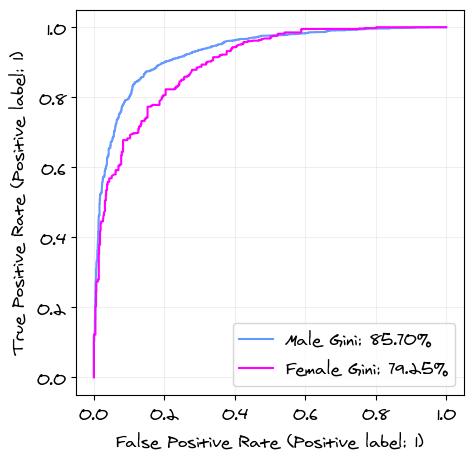

In [76]:
from matplotlib import pyplot as plt
from sklearn.metrics import RocCurveDisplay

label_column = y_b.loc[ix_train_b].copy()
prediction_column = xgb_clf.predict_proba(X_b.loc[ix_train_b])[:, 1]
group_column = A_b.loc[ix_train_b].copy()

roc_data = pd.DataFrame(
    {"label": label_column, "proba": prediction_column, "group": group_column}
)

ax_roc_curve = plt.subplots(figsize=(5, 5))[1]
colors = ["#fe595f", "#52a1ec"]
groups = ["Male", "Female"]

colors = plt.get_cmap("cool")(np.linspace(0.4, 1, 2))
# change font size
plt.rcParams.update({"font.size": 12})

for i, group in enumerate([0, 1]):
    roc_group = roc_data[roc_data["group"] == group]
    label = f"{groups[i]}"
    gini = roc_auc_score(roc_group["label"], roc_group["proba"]) * 2 - 1
    RocCurveDisplay.from_predictions(
        roc_group["label"],
        roc_group["proba"],
        name=label,
        label=f"{label} Gini: {gini:.2%}",
        ax=ax_roc_curve,
        color=colors[group],
    )
plt.grid(alpha=0.2)

In [77]:
# adopted from here: https://andrewpwheeler.com/2020/01/05/balancing-false-positives/

dataset_sorted = dataset.copy()

for cat in categorical_features:
    dataset_sorted[cat] = dataset_sorted[cat].astype("category")

dataset_sorted["prob"] = xgb_clf.predict_proba(dataset_sorted[X.columns])[:, 1]
dataset_sorted["prob_min"] = xgb_clf.predict_proba(dataset_sorted[X.columns])[:, 0]

dataset_sorted.sort_values(by=["Gender", "prob"], ascending=False, inplace=True)

dataset_sorted["const"] = 1
dataset_sorted["cum_fp"] = dataset_sorted.groupby(["Gender"])["prob_min"].cumsum()
dataset_sorted["cum_n"] = dataset_sorted.groupby(["Gender"])["const"].cumsum()
dataset_sorted["cum_fpm"] = dataset_sorted["cum_fp"] / dataset_sorted["cum_n"]
male_rt = dataset_sorted[dataset_sorted["Gender"] == "Male"]
female_rt = dataset_sorted[dataset_sorted["Gender"] == "Female"]

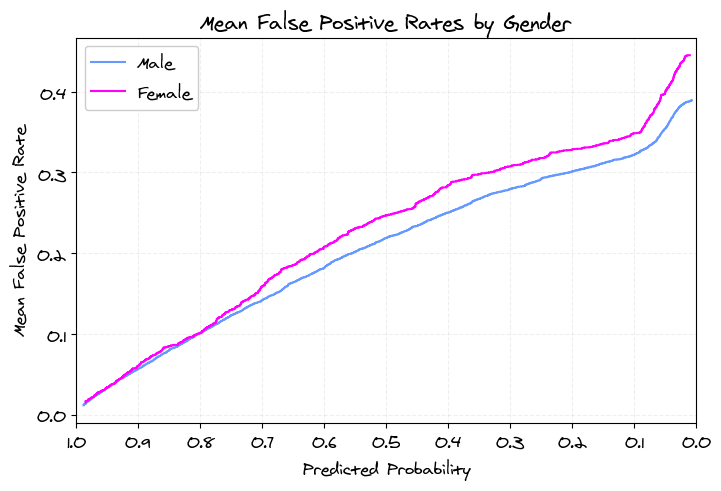

In [117]:
# now make the chart for Male and Female
colors = plt.get_cmap("cool")(np.linspace(0.4, 1, 2))

fig, ax = plt.subplots(figsize=(8, 5), dpi=100)
ax.plot(
    male_rt["prob"],
    male_rt["cum_fpm"],
    drawstyle="steps",
    color=colors[0],
    label="Male",
)
ax.plot(
    female_rt["prob"],
    female_rt["cum_fpm"],
    drawstyle="steps",
    color=colors[1],
    label="Female",
)
ax.set_xlim(1, 0)  # decreasing time
plt.xticks(np.arange(1.0, -0.1, -0.1))
ax.set_xlabel("Predicted Probability")
ax.set_ylabel("Mean False Positive Rate")
ax.grid(True, linestyle="--", alpha=0.2)
ax.legend(facecolor="white", framealpha=1)
ax.set_title("Mean False Positive Rates by Gender")
# plt.savefig('FP_Rate.png', dpi=2000, bbox_inches='tight')
plt.show()

In [115]:
from fairlearn.metrics import (
    MetricFrame,
    selection_rate,
    true_positive_rate,
    false_positive_rate,
    equalized_odds_difference,
    equalized_odds_ratio,
    demographic_parity_ratio,
)

metrics = {
    "selection_rate": selection_rate,
    "true_positive_rate": true_positive_rate,
    "false_positive_rate": false_positive_rate,
}

mf1 = MetricFrame(
    metrics=metrics,
    y_true=y_b.loc[ix_test_b],
    y_pred=xgb_clf.predict(X_b.loc[ix_test_b]),
    sensitive_features=A_b.loc[ix_test_b],
)

print(mf1.by_group)

                 selection_rate  true_positive_rate  false_positive_rate
Sensitive_Group                                                         
0                      0.534025            0.847516             0.214327
1                      0.493639            0.822823             0.251656


In [116]:
# Report additional metrics
equalized_odds_unmitigated = equalized_odds_difference(
    y_b.loc[ix_test_b],
    xgb_clf.predict(X_b.loc[ix_test_b]),
    sensitive_features=A_b.loc[ix_test_b],
)
print(f"Eq Odds Unmitigated: {equalized_odds_unmitigated:.2%}")

parity_unmitigated = demographic_parity_ratio(
    y_b.loc[ix_test_b],
    xgb_clf.predict(X_b.loc[ix_test_b]),
    sensitive_features=A_b.loc[ix_test_b],
)
print(f"Parity Unmitigated: {parity_unmitigated:.2%}")

odds_ratio_unmitigated = equalized_odds_ratio(
    y_b.loc[ix_test_b],
    xgb_clf.predict(X_b.loc[ix_test_b]),
    sensitive_features=A_b.loc[ix_test_b],
)
print(f"Eq Odds Ratio Unmitigated: {odds_ratio_unmitigated:.2%}")

Eq Odds Unmitigated: 3.73%
Parity Unmitigated: 92.44%
Eq Odds Ratio Unmitigated: 85.17%


### <span style="font-family: Virgil GS, sans-serif; color:navyblue">Bias-mitigated model</span>

In [230]:
from fairlearn.postprocessing import ThresholdOptimizer

import warnings

warnings.simplefilter("ignore", FutureWarning)

postprocess_est = ThresholdOptimizer(
    estimator=xgb_clf,
    constraints="equalized_odds",  # match TPR and FPR across groups
    objective="accuracy_score",
    prefit=True,
    predict_method="auto",
    flip=True,
)

# Fit a ThresholdOptimizer
postprocess_est.fit(
    X=X_b.loc[ix_train_b], y=y_b.loc[ix_train_b], sensitive_features=A_b.loc[ix_train_b]
)

postprocess_pred = postprocess_est.predict(
    X_b.loc[ix_test_b], sensitive_features=A_b.loc[ix_test_b], random_state=42
)

postprocess_pred_proba = postprocess_est._pmf_predict(
    X_b.loc[ix_test_b], sensitive_features=A_b.loc[ix_test_b]
)

In [231]:
from fairlearn.metrics import (
    MetricFrame,
    selection_rate,
    true_positive_rate,
    false_positive_rate,
    equalized_odds_difference,
    equalized_odds_ratio,
    demographic_parity_ratio,
)

metrics = {
    "selection_rate": selection_rate,
    "true_positive_rate": true_positive_rate,
    "false_positive_rate": false_positive_rate,
}

mf1 = MetricFrame(
    metrics=metrics,
    y_true=y_b.loc[ix_test_b],
    y_pred=postprocess_pred,
    sensitive_features=A_b.loc[ix_test_b],
)

print(mf1.by_group)

                 selection_rate  true_positive_rate  false_positive_rate
Sensitive_Group                                                         
0                      0.492215            0.757282             0.221899
1                      0.430025            0.726727             0.211921


In [232]:
# Report additional metrics
equalized_odds_mitigated = equalized_odds_difference(
    y_b.loc[ix_test_b],
    postprocess_pred,
    sensitive_features=A_b.loc[ix_test_b],
)
print(f"Eq Odds Unmitigated: {equalized_odds_mitigated:.2%}")

parity_mitigated = demographic_parity_ratio(
    y_b.loc[ix_test_b],
    postprocess_pred,
    sensitive_features=A_b.loc[ix_test_b],
)
print(f"Parity Unmitigated: {parity_mitigated:.2%}")

odds_ratio_mitigated = equalized_odds_ratio(
    y_b.loc[ix_test_b],
    postprocess_pred,
    sensitive_features=A_b.loc[ix_test_b],
)
print(f"Eq Odds Ratio Unmitigated: {odds_ratio_mitigated:.2%}")

Eq Odds Unmitigated: 3.06%
Parity Unmitigated: 87.37%
Eq Odds Ratio Unmitigated: 95.50%


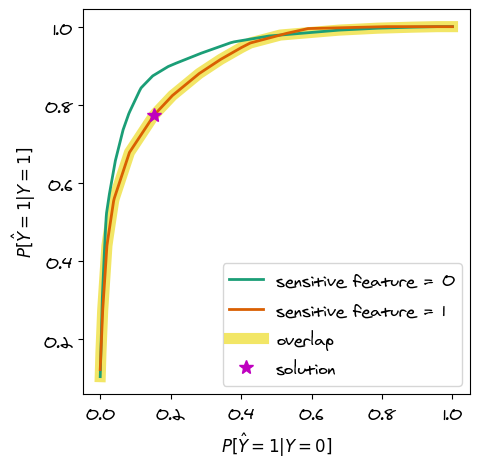

In [233]:
from fairlearn.postprocessing import plot_threshold_optimizer

figure, ax = plt.subplots(figsize=(5, 5), dpi=100)
plot_threshold_optimizer(postprocess_est, ax=ax, show_plot=True)
plt.show()

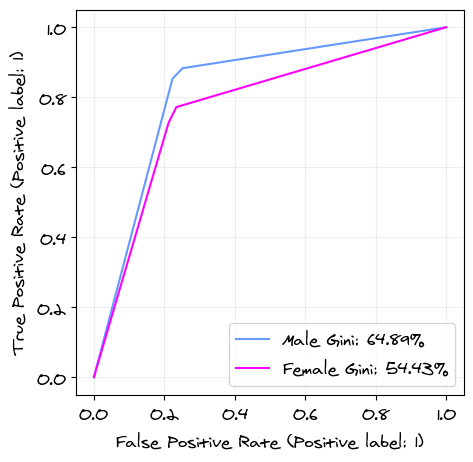

In [234]:
from matplotlib import pyplot as plt
from sklearn.metrics import RocCurveDisplay

label_column = y_b.loc[ix_test_b].copy()
prediction_column = postprocess_est._pmf_predict(
    X_b.loc[ix_test_b], sensitive_features=A_b.loc[ix_test_b]
)[:, 1]
group_column = A_b.loc[ix_test_b].copy()

roc_data = pd.DataFrame(
    {"label": label_column, "proba": prediction_column, "group": group_column}
)

ax_roc_curve = plt.subplots(figsize=(5, 5))[1]
colors = ["#fe595f", "#52a1ec"]
groups = ["Male", "Female"]

colors = plt.get_cmap("cool")(np.linspace(0.4, 1, 2))
# change font size
plt.rcParams.update({"font.size": 12})

for i, group in enumerate([0, 1]):
    roc_group = roc_data[roc_data["group"] == group]
    label = f"{groups[i]}"
    gini = roc_auc_score(roc_group["label"], roc_group["proba"]) * 2 - 1
    RocCurveDisplay.from_predictions(
        roc_group["label"],
        roc_group["proba"],
        name=label,
        label=f"{label} Gini: {gini:.2%}",
        ax=ax_roc_curve,
        color=colors[group],
    )
plt.grid(alpha=0.2)